In [1]:
import zipfile
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
with zipfile.ZipFile('Face_recognition_dataset.zip') as files:
  files.extractall()

In [3]:
data_path = 'Face_recognition_dataset'

In [4]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# Load dataset
data = datasets.ImageFolder(root=data_path, transform=data_transforms)
data_size = len(data)
train_size = int(0.7 * data_size)
val_size = int(0.2 * data_size)
test_size = data_size - train_size - val_size

train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [6]:
# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 40)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        # Reshape the tensor with the correct batch size
        x = x.view(-1, 64 * 64 * 64)  # Updated reshape operation
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
# Loss and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images, labels

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images, labels
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [12]:
# Train the model
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=50)

Epoch 1/50, Train Loss: 0.4664, Validation Loss: 0.3566
Epoch 2/50, Train Loss: 0.5180, Validation Loss: 0.4887
Epoch 3/50, Train Loss: 0.4071, Validation Loss: 0.3646
Epoch 4/50, Train Loss: 0.5085, Validation Loss: 0.2689
Epoch 5/50, Train Loss: 0.4694, Validation Loss: 0.3887
Epoch 6/50, Train Loss: 0.4957, Validation Loss: 0.2967
Epoch 7/50, Train Loss: 0.4380, Validation Loss: 0.3605
Epoch 8/50, Train Loss: 0.2658, Validation Loss: 0.4461
Epoch 9/50, Train Loss: 0.3582, Validation Loss: 0.4213
Epoch 10/50, Train Loss: 0.4149, Validation Loss: 0.2889
Epoch 11/50, Train Loss: 0.4528, Validation Loss: 0.3337
Epoch 12/50, Train Loss: 0.4129, Validation Loss: 0.3958
Epoch 13/50, Train Loss: 0.4434, Validation Loss: 0.3717
Epoch 14/50, Train Loss: 0.3837, Validation Loss: 0.4084
Epoch 15/50, Train Loss: 0.4200, Validation Loss: 0.3134
Epoch 16/50, Train Loss: 0.2687, Validation Loss: 0.3400
Epoch 17/50, Train Loss: 0.3552, Validation Loss: 0.3324
Epoch 18/50, Train Loss: 0.3553, Validat

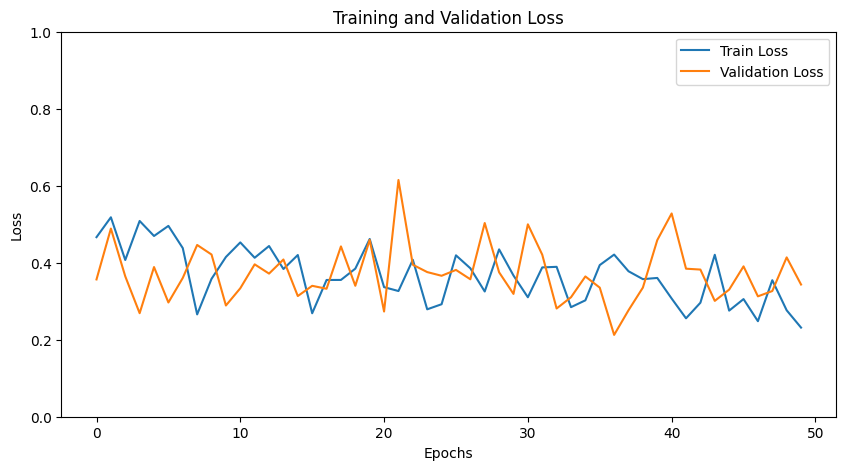

In [16]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Test function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate the model on test data
test_model(model, test_loader)

Test Accuracy: 92.50%
